In [168]:
import numpy as np
import scipy.spatial.distance

In [360]:
class RepresentativePoints:
    
    def __init__(self, data):
        self.data = data
        self.n_dimensions = data.shape[1]
        
    def _generate_full_sample(self):
        meshgrid = np.meshgrid(*[np.linspace(0, 1, 10, dtype=np.float16) for _ in range(self.n_dimensions)])
        full_grid = np.array([x.flatten() for x in meshgrid], dtype=np.float16).T
        return full_grid
    
    def _find_distances(self):
        full_grid = self._generate_full_sample()
        distances = scipy.spatial.distance.cdist(self.data, full_grid, metric='euclidean')
        return distances
    
    def find_most_representative_sample(self, n=1):
        dists = self._find_distances()
        best_idx = min(itertools.combinations(range(self.data.shape[0]), n),
                       key=lambda inds: dists[inds, :].min(axis=0).max())
        return self.data[list(best_idx)]
    
    def find_ultimate_per_col(self, df, n=20):
        ultimate_indices = set()
        for col in df.columns:
            args = df[col].argsort()
            for ind in args.values[:n]:
                ultimate_indices.add(ind)
            for ind in args.values[-n:]:
                ultimate_indices.add(ind)
        return df.loc[ultimate_indices]

    def find_best_spread(self, n=2, n_ultimate_per_col=None):
        assert n >= 2
        min_spread = 0
        best_inds = None
        for inds in itertools.combinations(range(self.data.shape[0]), n):
            selected_data = self.data[list(inds), :]
            spread = selected_data.max(axis=0) - selected_data.min(axis=0)
            this_spread = spread.min() # TODO: could also be a quadratic sum or smth
            if this_spread > min_spread:
                min_spread = this_spread
                best_inds = inds
        return best_inds
    
    def find_best_spread_df(self, n_ultimate_per_col=20):
        df = pd.DataFrame(self.data)
        if len(df) > 1000:
            df = self.find_ultimate_per_col(df, n_ultimate_per_col)
            
        m = df.reset_index().melt(id_vars=['index'])
        inds = (m.merge(m, on='variable')
         .query('index_x > index_y')
         .assign(spread=lambda df: df['value_y'].sub(df['value_x']).abs())
         .groupby(['index_x', 'index_y'])['spread'].min()
         .idxmax()
        )
        return inds

In [387]:
datapoints = np.random.uniform(size=(1001, 40))
r = RepresentativePoints(datapoints)

In [388]:
%%time
spreaders = r.find_best_spread_df()

Wall time: 5.43 s


In [389]:
%%time
r.find_best_spread()

Wall time: 10.1 s


(24, 193)

In [379]:
np.abs(datapoints[132] - datapoints[74]).min()

0.5037312856919405

In [380]:
np.abs(datapoints[312] - datapoints[100]).min()

0.49002647963618695

In [382]:
datapoints[312]

array([0.94194671, 0.81534107, 0.70804223, 0.59791889, 0.66926762,
       0.99880667, 0.58909181, 0.75260616, 0.48988528])

In [384]:
datapoints[list(spreaders), :]

array([[0.94194671, 0.81534107, 0.70804223, 0.59791889, 0.66926762,
        0.99880667, 0.58909181, 0.75260616, 0.48988528],
       [0.24210459, 0.00212954, 0.19948527, 0.04554818, 0.14968647,
        0.42420499, 0.08725703, 0.14527355, 0.97991176]])

In [335]:
import pandas as pd
df = pd.DataFrame(datapoints)

In [327]:
%%time
spreaders = r.find_best_spread(2)

Wall time: 9.18 s


In [333]:
spreaders

(174, 629)

In [315]:
spreaders

(29, 30)

KeyboardInterrupt: 

In [ ]:
datapoints[list(spreaders)]

In [278]:
%%time
datapoints = np.random.uniform(size=(70, 5))
r = RepresentativePoints(datapoints)
r.find_most_representative_sample()

Wall time: 195 ms


array([[0.42228715, 0.70110743, 0.64962702, 0.4923455 , 0.61564287]])

In [279]:
%%time
r.find_most_representative_sample(2)

Wall time: 2.82 s


array([[0.42228715, 0.70110743, 0.64962702, 0.4923455 , 0.61564287],
       [0.53586662, 0.0697361 , 0.26663569, 0.62049948, 0.28076533]])

In [252]:
%%time
chose_points = r.find_most_representative_sample(3)

Wall time: 2.86 s


(0.0, 1.0)

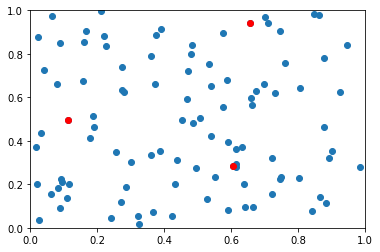

In [258]:
import matplotlib.pyplot as plt
plt.scatter(datapoints[:, 0], datapoints[:, 1])
plt.scatter(chose_points[:, 0], chose_points[:, 1], c='r')
plt.xlim(0, 1)
plt.ylim(0, 1)